In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import glob
import random
import cv2
import imutils
from skimage import color
from skimage.util.dtype import convert
import import_ipynb #pip install import-ipynb

from data import ImageNet, VisionDataset
from CUnet import CUNet
from eccv16 import eccv16

importing Jupyter notebook from data.ipynb
importing Jupyter notebook from CUnet.ipynb
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
importing Jupyter notebook from eccv16.ipynb


## Define models and data loaders

In [2]:
cu_model = CUNet()
ecc_model = eccv16()

In [3]:
trans = transforms.Compose([transforms.ToTensor()])
ImageNet_train_dataset = ImageNet(root="./imagenet/train", transform=trans, size=20)
ImageNet_eval_dataset = ImageNet(root="./imagenet/val", transform=trans, size=20)

In [4]:
train_dataloader_imagenet = DataLoader(ImageNet_train_dataset, batch_size=32, shuffle=True)
eval_dataloader_imagenet = DataLoader(ImageNet_eval_dataset, batch_size=32, shuffle=True)

## Define Hyper params

In [49]:
EPOCHS = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(cu_model.parameters(), lr=0.001) #change as needed
loss_function = torch.nn.MSELoss() #change as needed

## Define Train and eval functions

In [6]:
def train_model(dataloader, model, device, optimizer, loss_function, epochs=1, epoch_offset=0):
    for epoch in range(epoch_offset+1, epochs+epoch_offset+1):
        model.train()
        train_loss = 0
        for batch_index,(inputs, expected) in enumerate(dataloader):
            optimizer.zero_grad() 
            inputs = inputs.to(device)
            expected = expected.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, expected)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(expected)
        print("Epoch",epoch,"Done")
        if epoch%2==0:
            filename = f'model/{type(model).__name__}_{epoch}_{train_loss}.pth'
            torch.save(model.state_dict(), filename)

In [7]:
# Needs to be fixed, has to calculate accuracy and print loss
def eval_model(dataloader, model, device, loss_function):
    model.eval()
    val_loss = 0
    for batch_index,(inputs, expected) in enumerate(dataloader):
        # inputs = torchvision.transforms.ToTensor(train_dataloader_imagenet.resize_image(lightness))
        # expected = torchvision.transforms.ToTensor(train_dataloader_imagenet.resize_image(colors))
        # inputs.type(torch.float32)
        # expected.type(torch.float32)
        print(type(inputs))
        inputs = inputs.to(device)
        expected = expected.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, expected)
        val_loss += loss.item()*len(expected)
    avg_val_loss = val_loss/len(eval_dataloader_imagenet)
    print("Eval Loss")

In [48]:
def print_comparisons(start,model):
    for i in range(start,start+5):
        org1, pred1 = ImageNet_train_dataset.check_output(i,model)
        org1_resize = Image.fromarray((org1 * 255).astype(np.uint8)).resize((256,256)) # get resize image 
        
        figure, axes = plt.subplots(1, 2, figsize=(18,10))
        axes = axes.flatten()
        axes[0].imshow(org1_resize) # show resized image instead of original size image
        axes[1].imshow(pred1)

In [9]:
def name_to_epoch(name):
    _, epoch, _ = name.split("_") #name, epoch, avg_l.pth
    return(int(epoch))

In [10]:
def get_latest_weights(model):
    paths = glob.glob(f'model/{type(model).__name__}_*.pth')
    #only find models that have the same type as the model being trained
    
    paths.sort(key = name_to_epoch) #most recent epoch
    start = -1
    if len(paths) > 0:
        target = paths[-1]
        start = name_to_epoch(target)
        model.load_state_dict(torch.load(target))
    return start

### Train Models

In [44]:
start = get_latest_weights(cu_model)
train_model(train_dataloader_imagenet, cu_model, device, optimizer, loss_function, 10, start)

Epoch 129 Done
Epoch 130 Done
Epoch 131 Done
Epoch 132 Done
Epoch 133 Done
Epoch 134 Done
Epoch 135 Done
Epoch 136 Done
Epoch 137 Done
Epoch 138 Done


In [ ]:
start = get_latest_weights(ecc_model)
train_model(train_dataloader_imagenet, ecc_model, device, optimizer, loss_function, EPOCHS, start)

### Eval Models

In [ ]:
# eval_model(eval_dataloader_imagenet, cu_model, device, loss_function)

In [ ]:
# eval_model(eval_dataloader_imagenet, ecc_model, device, loss_function)

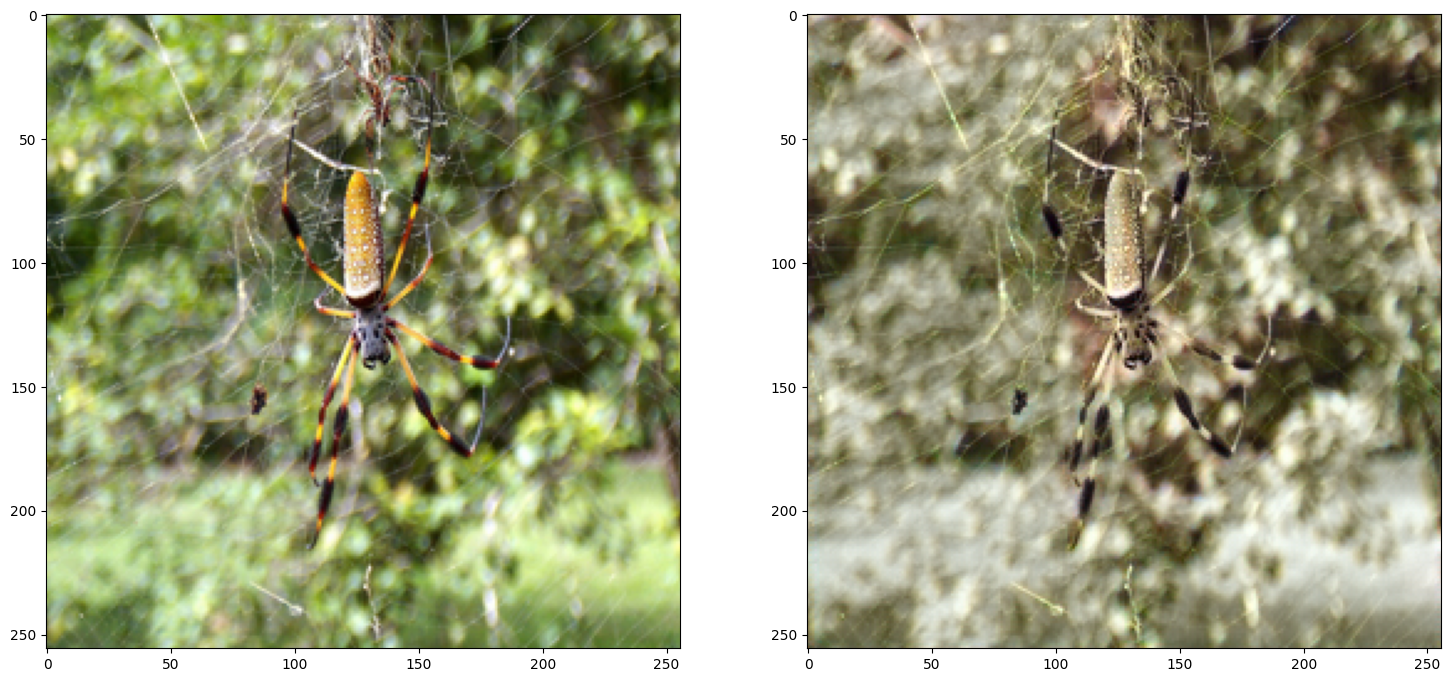

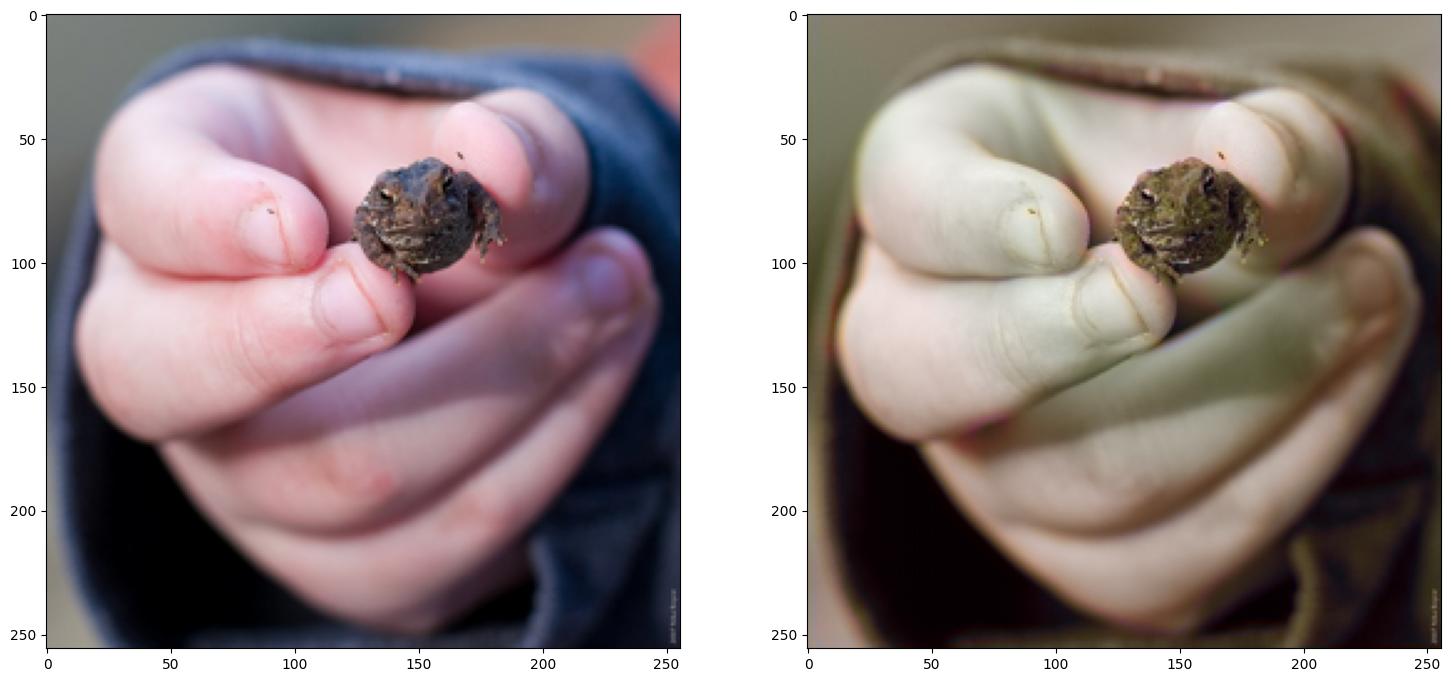

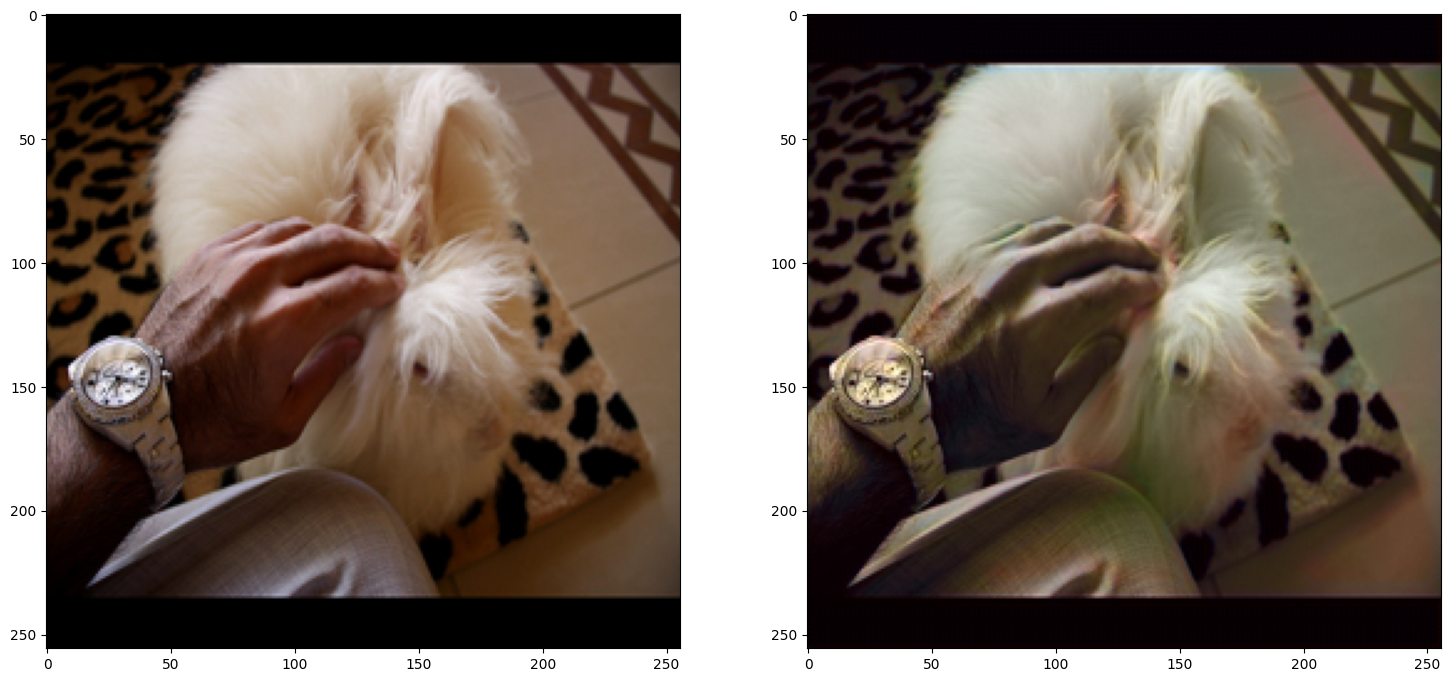

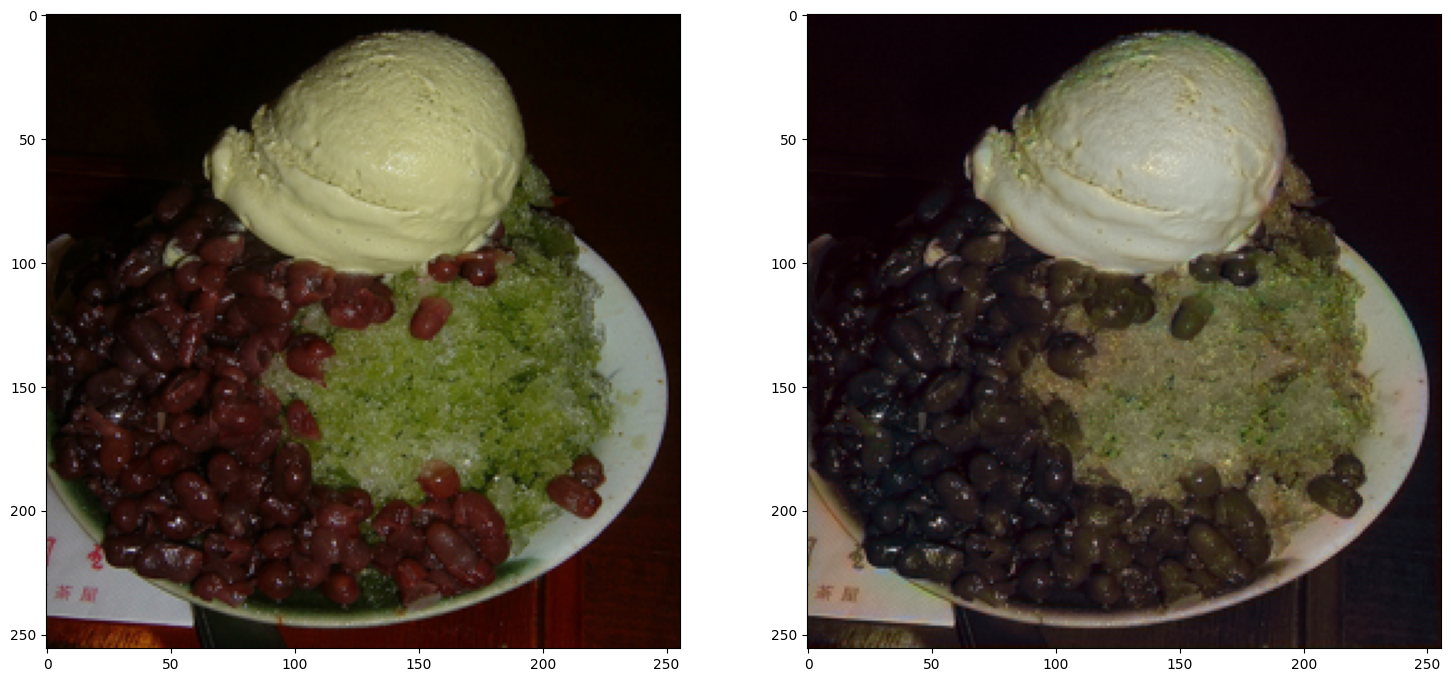

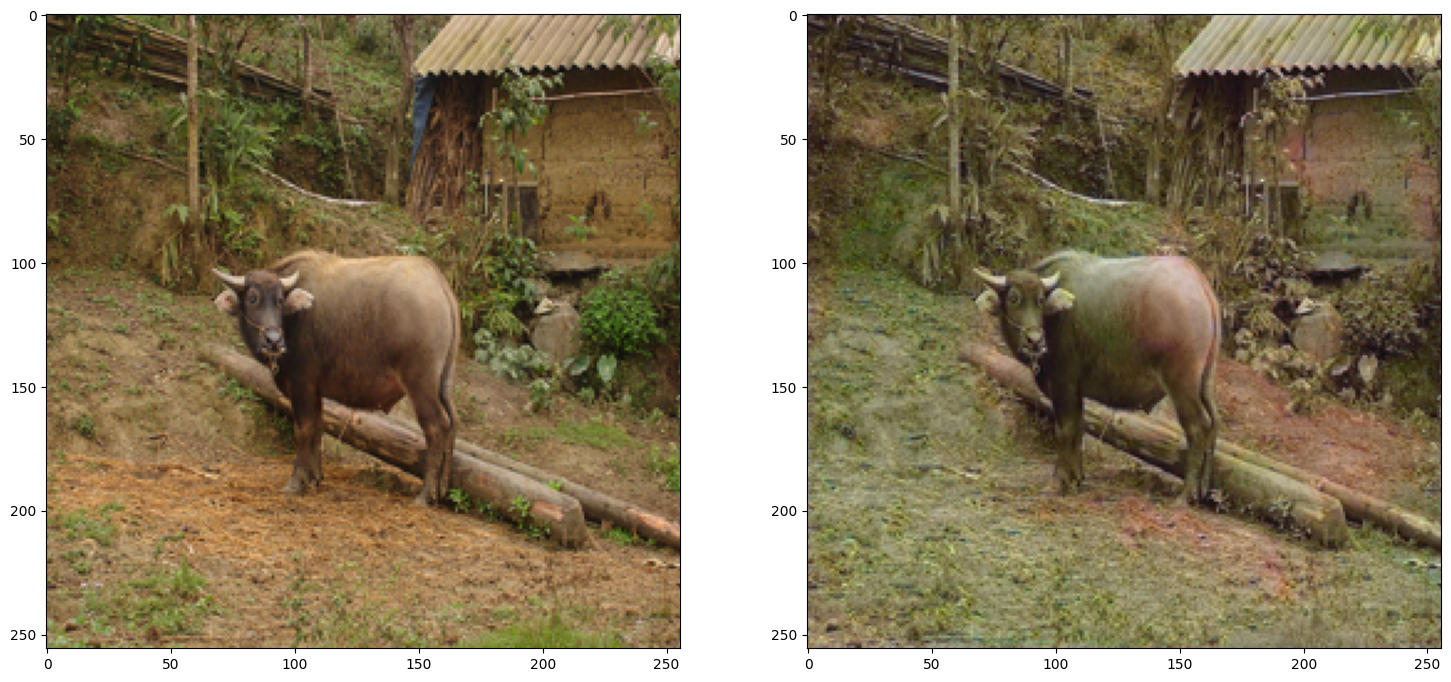

In [47]:
print_comparisons(1,cu_model)